In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from joblib import parallel_backend

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

from chesswinnerprediction.baseline.utils import (
    get_x_and_y,
    get_class_weights,
    transform_and_scale_df,
    get_worst_params_df,
    estimate_baseline_model,
)
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH

## Load Data

In [3]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
partial_train_df = train_df.sample(frac=0.15, random_state=42)
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [5]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
partial_train_data = transform_and_scale_df(
    partial_train_df, std_scaler, fit_scaler=False
)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scaler=False)

In [6]:
class_weights = get_class_weights(train_df["Result"], verbose=True)

Class weights:
	1-0: 0.6719252445731612
	0-1: 0.6972429817947734
	1/2-1/2: 12.900070154830079


In [7]:
x_train_data, y_train = get_x_and_y(train_data, predict_draws=True)
x_partial_train_data, y_partial_train = get_x_and_y(
    partial_train_data, predict_draws=True
)
x_valid_data, y_valid = get_x_and_y(valid_data, predict_draws=True)

## Random Forest

In [8]:
random_forest_params = {
    "n_estimators": [24, 32, 56],
    "max_depth": [10, 11, 12],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [1e-6, 1e-5, 1e-4, 1e-3],
    "min_samples_leaf": [1e-6, 1e-5, 1e-4, 1e-3],
    "min_impurity_decrease": [1e-6, 1e-5, 1e-4, 1e-3],
    "min_weight_fraction_leaf": [0.0, 1e-6, 1e-5, 1e-4, 1e-3],
    "max_leaf_nodes": [None, 350, 400, 450, 500],
}

forest_clf = RandomForestClassifier(
    class_weight=class_weights,
    verbose=0,
    n_jobs=-1,
    random_state=BASELINE_RANDOM_STATE,
)

random_search = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=random_forest_params,
    n_iter=16,
    cv=5,
    verbose=3,
    random_state=BASELINE_RANDOM_STATE,
    scoring="balanced_accuracy",
    return_train_score=True,
    refit=False,
)

In [ ]:
_ = random_search.fit(x_partial_train_data, y_partial_train)

In [10]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.46351496449727314
Best Parameters: {'n_estimators': 56, 'min_weight_fraction_leaf': 0.001, 'min_samples_split': 1e-06, 'min_samples_leaf': 0.0001, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 500, 'max_features': 'sqrt', 'max_depth': 12}


Let's take a look at the worst parameters.

In [11]:
get_worst_params_df(random_search.cv_results_).head(5)

mean_test_score
param_n_estimators param_min_weight_fraction_leaf param_min_samples_split param_min_samples_leaf param_min_impurity_decrease param_max_leaf_nodes param_max_features param_max_depth                 
24                 0.000000                       0.000010                0.000100               0.000100                    450                  0.5                12                      0.451319
32                 0.000001                       0.000001                0.000001               0.001000                    350                  sqrt               11                      0.453796
56                 0.000000                       0.000001                0.000100               0.001000                    400                  sqrt               12                      0.454577
                   0.000010                       0.000010                0.000010               0.001000                    350                  sqrt               11                      0.454577
                                                  0.000100                0.000001               0.000001                    450                  sqrt               12                      0.454928

## Fit Best Model With All Data

In [16]:
args = {
    "n_estimators": 24,
    "min_weight_fraction_leaf": 0.0,
    "min_samples_split": 1e-06,
    "min_samples_leaf": 0.001,
    "min_impurity_decrease": 0.0001,
    "max_leaf_nodes": 350,
    "max_features": 0.5,
    "max_depth": 10,
    "class_weight": class_weights,
    "random_state": BASELINE_RANDOM_STATE,
    "n_jobs": -1,
}

best_forest_clf = RandomForestClassifier(**args)

In [17]:
best_forest_clf = best_forest_clf.fit(x_train_data, y_train)

Log Loss on test data: 1.0334
Balanced Accuracy on test data: 46.93%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.61      0.40      0.48    378005              0.61      0.40      0.48     45215
         1-0       0.61      0.44      0.51    392248              0.61      0.45      0.51     47511
     1/2-1/2       0.05      0.58      0.08     20431              0.05      0.57      0.09      2537
    accuracy                           0.42    790684                                  0.43     95263
   macro avg       0.42      0.47      0.36    790684              0.42      0.47      0.36     95263
weighted avg       0.59      0.42      0.49    790684              0.59      0.43      0.49     95263
       


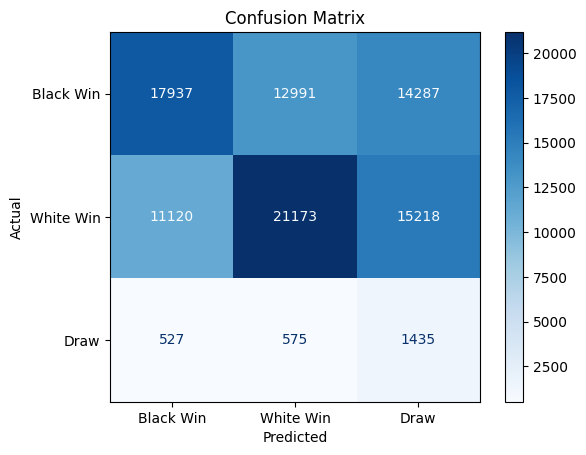

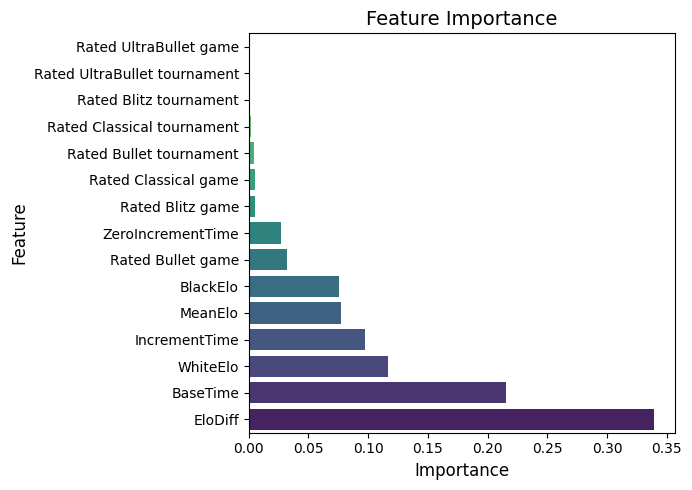

In [18]:
feature_importance = best_forest_clf.feature_importances_.reshape(1, -1)

estimate_baseline_model(
    best_forest_clf, feature_importance, x_train_data, y_train, x_valid_data, y_valid
)

## Gradient Boosting

In [19]:
gradient_boosting_params = {
    "n_estimators": [10, 30, 90],
    "max_depth": [2, 4, 6],
    "max_features": ["sqrt"],
    "learning_rate": [0.1, 0.01],
    "tol": [1e-2],
    "min_samples_split": [1e-3, 1e-4, 1e-5, 1e-6],
    "min_samples_leaf": [1e-3, 1e-4, 1e-5, 1e-6],
    "min_impurity_decrease": [0.0, 1e-3, 1e-4, 1e-5, 1e-6],
    "min_weight_fraction_leaf": [0.0, 1e-3, 1e-4, 1e-5, 1e-6],
}

boosting_clf = GradientBoostingClassifier(verbose=0, validation_fraction=0.1)

random_search = RandomizedSearchCV(
    estimator=boosting_clf,
    param_distributions=gradient_boosting_params,
    n_iter=16,
    cv=5,
    verbose=3,
    random_state=42,
    scoring="balanced_accuracy",
    return_train_score=True,
    # pre_dispatch=7,
    n_jobs=-1,
    refit=False,
)

In [ ]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_partial_train)

with parallel_backend("multiprocessing"):
    random_search.fit(
        x_partial_train_data, y_partial_train, sample_weight=sample_weights
    )

In [21]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.4627381585768898
Best Parameters: {'tol': 0.01, 'n_estimators': 10, 'min_weight_fraction_leaf': 0.0, 'min_samples_split': 1e-05, 'min_samples_leaf': 0.001, 'min_impurity_decrease': 1e-06, 'max_features': 'sqrt', 'max_depth': 6, 'learning_rate': 0.1}


In [22]:
get_worst_params_df(random_search.cv_results_).head(5)

mean_test_score
param_tol param_n_estimators param_min_weight_fraction_leaf param_min_samples_split param_min_samples_leaf param_min_impurity_decrease param_max_features param_max_depth param_learning_rate                 
0.01      10                 0.000100                       0.001000                0.000010               0.00001                     sqrt               2               0.01                        0.442722
                             0.000010                       0.000001                0.000100               0.00000                     sqrt               2               0.01                        0.446293
                             0.000000                       0.000001                0.000001               0.00001                     sqrt               2               0.01                        0.450112
                             0.000001                       0.000010                0.001000               0.00100                     sqrt               2               0.01                        0.451898
                             0.000000                       0.000010                0.000010               0.00100                     sqrt               2               0.10                        0.452039

## Fit Best Model With All Data

In [25]:
args = {
    "tol": 0.01,
    "n_estimators": 100,
    "min_weight_fraction_leaf": 0.0,
    "min_samples_split": 0.001,
    "min_samples_leaf": 1e-06,
    "min_impurity_decrease": 0.0,
    "max_features": "sqrt",
    "max_depth": 6,
    "learning_rate": 0.1,
    "random_state": BASELINE_RANDOM_STATE,
    "verbose": 3,
}

best_boosting_clf = GradientBoostingClassifier(**args)

In [ ]:
sample_weights = compute_sample_weight(class_weight="balanced", y=y_train)

best_boosting_clf.fit(x_train_data, y_train, sample_weight=sample_weights)

Log Loss on test data: 1.0243
Balanced Accuracy on test data: 47.14%


                                                Classification Report
                         Train Report                                      Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.60      0.44      0.51    378005              0.60      0.44      0.50     45215
         1-0       0.63      0.42      0.50    392248              0.62      0.42      0.50     47511
     1/2-1/2       0.05      0.59      0.09     20431              0.05      0.55      0.09      2537
    accuracy                           0.44    790684                                  0.43     95263
   macro avg       0.43      0.49      0.37    790684              0.42      0.47      0.36     95263
weighted avg       0.60      0.44      0.50    790684              0.59      0.43      0.49     95263
       


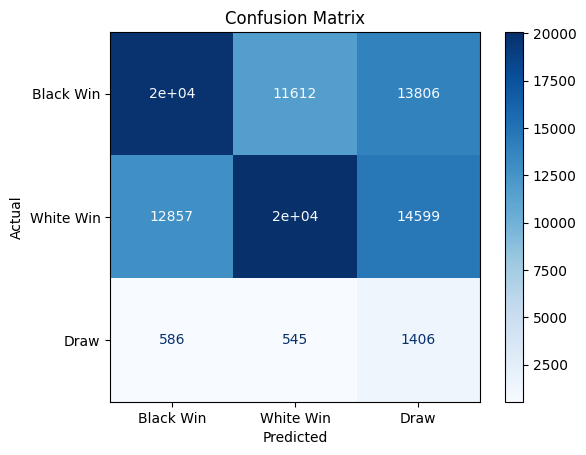

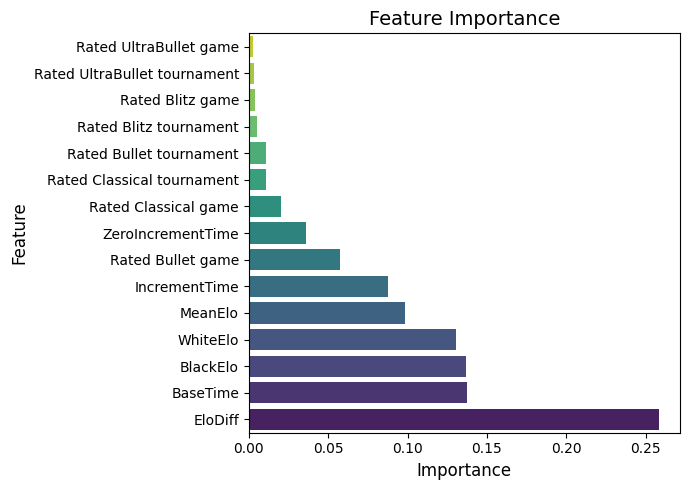

In [27]:
feature_importance = best_boosting_clf.feature_importances_.reshape(1, -1)

estimate_baseline_model(
    best_boosting_clf, feature_importance, x_train_data, y_train, x_valid_data, y_valid
)